# Ejemplo segmentación

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ja.meza@profesor.duoc.cl

**Fecha de Creación:** Diciembre de 2025   
**Versión:** 1.0  


---

## Descripción

Este notebook muestra la segmentación de estudiantes

En este caso sólo aplica K-Means

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.12. A continuación se listan las bibliotecas necesarias:

- pandas (>=1.1.0)
- numpy (1.26.4)
- matplotlib (3.7.1)
- seaborn (0.13.1)
- sklearn (1.3.2)

Para verificar la versión instalada ejecutar usando el nombre del paquete del cual quieres saber la versión; por ejemplo, si quieres saber la versión de sklearn usas:

```python
import sklearn
print(sklearn.__version__)
````

# K-means

El algoritmo trabaja iterativamente para asignar a cada “punto” (las filas del conjunto de entrada forman una coordenada) uno de los “K” grupos basado en sus características. Son agrupados en base a la similitud de sus features (las columnas).

Resultados de ejecutar el algoritmo:

+ Los “centroids” de cada grupo que serán unas “coordenadas” de cada uno de los K conjuntos que se utilizarán para poder etiquetar nuevas muestras.

+ Etiquetas para el conjunto de datos de entrenamiento. Cada etiqueta perteneciente a uno de los K grupos formados.

Los grupos se van definiendo de manera “orgánica”, es decir, que se va ajustando su posición en cada iteración del proceso, hasta que converge el algoritmo. Una vez encontrados los centroids se deben analizar para ver cuáles son sus características únicas, frente a la de los otros grupos. Estos grupos son las etiquetas que genera el algoritmo.

## Dónde usar K-means

El algoritmo de Clustering K-means es uno de los más usados para encontrar grupos ocultos, o sospechados en teoría sobre un conjunto de datos no etiquetado. Esto puede servir para confirmar -o desterrar- alguna teoría que se tenga asumida de los datos.

También puede ayudar a descubrir relaciones asombrosas entre conjuntos de datos, que de manera manual, no se hubieran reconocido. Una vez que el algoritmo ha ejecutado y obtenido las etiquetas, será fácil clasificar nuevos valores o muestras entre los grupos obtenidos.

### Algunos usos:

+ Segmentación por comportamiento: relacionar el carrito de compras de un usuario, sus tiempos de acción e información del perfil.
+ Categorización de productos: agrupar productos por actividad en sus ventas.
+ Detectar anomalías o actividades sospechosas: según el comportamiento en una web reconocer un troll -o un bot- de un usuario normal.

## Características de las entradas

Las “features” o características que se utilicen como entradas para aplicar el algoritmo k-means deberán ser de valores numéricos, continuos en lo posible. En caso de valores categóricos se puede intentar pasarlo a valor numérico, pero no es recomendable pues no hay una “distancia real”.

Es recomendable que los valores utilizados estén **normalizados**, manteniendo una misma escala. En algunos casos también funcionan mejor datos porcentuales en vez de absolutos.

No conviene utilizar features que estén correlacionados o que sean escalares de otros.

## Funcionamiento de K-means

El algoritmo utiliza una proceso iterativo en el que se van ajustando los grupos para producir el resultado final. Para ejecutar el algoritmo se debe pasar como entrada el conjunto de datos y un valor de K.

El conjunto de datos serán las características o features para cada punto. Las posiciones iniciales de los K centroides serán asignadas de manera aleatoria de cualquier punto del conjunto de datos de entrada. Luego se itera en dos pasos:

### PASO 1- Asignación de datos

Cada “fila” del conjunto de datos se asigna al centroide más cercano basado en la distancia cuadrada Euclideana. Se utiliza la siguiente fórmula (donde dist() es la distancia Euclideana standard):

argmin $dist(c_{i},x)^{2}$ con $c_{i} \in C$

### PASO 2 - Actualización de centroide

Los centroides de cada grupo son recalculados. Esto se hace tomando una media de todos los puntos asignados en el paso anterior.

$c_{i} = \frac{1}{|S_{i}|}\sum_{x_i \in S_i} x_{i}$

El algoritmo itera entre estos pasos hasta cumplir uno de los criterios de detención:

+ Si no hay cambios en los puntos asignados a los grupos,
+ Si la suma de las distancias se minimiza,
+ Se alcanza un número máximo de iteraciones.

In [1]:
!pip install kneed

## Aplicación de K-Means

Usando dataset de desempeño de estudiantes

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score, calinski_harabasz_score, davies_bouldin_score

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from kneed import KneeLocator

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin

plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('ggplot')

In [26]:
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=(0.05, 0.05)):
        self.limits = limits

    def fit(self, X, y=None):
        # Guardar nombres si es DataFrame, si no generar nombres genéricos
        if isinstance(X, pd.DataFrame):
            self.columns_ = X.columns
        else:
            self.columns_ = np.arange(X.shape[1])
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.columns_)
        for col in self.columns_:
            lower = X[col].quantile(self.limits[0])
            upper = X[col].quantile(1 - self.limits[1])
            X[col] = np.clip(X[col], lower, upper)
        return X.values

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array(self.columns_)
        else:
            return np.array(input_features)

In [3]:
!wget https://www.dropbox.com/s/k82c8fw6hmjxuh0/dataset_StudentsPerformance.csv

--2026-01-19 00:44:18--  https://www.dropbox.com/s/k82c8fw6hmjxuh0/dataset_StudentsPerformance.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/2k376qmmcgl2by57e0oi4/dataset_StudentsPerformance.csv?rlkey=k3lcm5s1sdhcjgthrvcanuo70 [following]
--2026-01-19 00:44:18--  https://www.dropbox.com/scl/fi/2k376qmmcgl2by57e0oi4/dataset_StudentsPerformance.csv?rlkey=k3lcm5s1sdhcjgthrvcanuo70
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca7e5c07720558e6bcc86863530.dl.dropboxusercontent.com/cd/0/inline/C5O5JTkePNxiDzRr0siX_39UEuXwc7Aw7TSwn1iewXaierwUdbYXbMonwtBd03wRLG5u9Ykl0m56HYh1A08JUlVYDdlUCnMnpA3rVdS-54WzTTwMsXumJLbgyghu83u50E2ReNzZxe4bYWUTp8V3EsHW/file# [following]
--2026-01-19 00:44:19--  https://uca7e5c0772

In [4]:
data_frame = pd.read_csv("dataset_StudentsPerformance.csv")
data_frame.head()

,user,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,1,female,group B,bachelor's degree,standard,none,72,72,74
1,2,female,group C,some college,standard,completed,69,90,88
2,3,female,group B,master's degree,standard,none,90,95,93
3,4,male,group A,associate's degree,free/reduced,none,47,57,44
4,5,male,group C,some college,standard,none,76,78,75


## Análisis exploratorio

In [5]:
data_frame.shape

(1000, 9)

In [6]:
data_frame.dtypes

,0
user,int64
gender,object
race/ethnicity,object
parental level of education,object
lunch,object
test preparation course,object
math score,int64
reading score,int64
writing score,int64


In [7]:
# Estandariza nombres de columnas
data_frame.columns = data_frame.columns.str.lower().str.replace(" ", "_", regex=True)
data_frame.columns

Index(['user', 'gender', 'race/ethnicity', 'parental_level_of_education',
       'lunch', 'test_preparation_course', 'math_score', 'reading_score',
       'writing_score'],
      dtype='object')

In [8]:
data_frame.query("math_score < 0 or writing_score < 0 or reading_score < 0")

,user,gender,race/ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score


In [9]:
data_frame.query("math_score > 100 or writing_score > 100 or reading_score > 100")

,user,gender,race/ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score


In [10]:
data_frame.query("math_score == 0 or writing_score == 0 or reading_score == 0")

,user,gender,race/ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
59,60,female,group C,some high school,free/reduced,none,0,17,10


In [11]:
# Obtiene cantidad de estudiantes por cada nivel de educación de los padres
data_frame.groupby('parental_level_of_education').size()

,0
parental_level_of_education,
associate's degree,222
bachelor's degree,118
high school,196
master's degree,59
some college,226
some high school,179


In [12]:
def view_graph_interactive(data_frame, x :str, y :str, hover : str, title : str) -> None:
    """ Muestra un gráfico interactivo considerando 3 columnas

    x str : nombre de la columna asociada al eje X
    y str : nombre de la columna asociada al eje Y
    hover str :nombre de la columna que se mostrará al pasar el mouse por la gráfica

    returns None
    """
    fig = px.scatter(data_frame, x = x, y = y, color = hover,
                 hover_name = data_frame[hover].values,  width = 600, height = 600,
                 labels = {'x' : x, 'y' : y, hover : hover}, title = title)
    fig.show()

In [13]:
features = ['math_score', 'reading_score', 'writing_score']
view_graph_interactive(data_frame[features], x="writing_score",
                       y="reading_score", hover="math_score",title="Relación entre puntajes")

En la gráfica anterior se aprecia una relación entre altos puntajes en las pruebas de lectura, escritura y la de matemáticas.

## Análisis de la distribución de los puntajes

Como una forma de identificar posibles sesgos en los puntajes se revisa la distribución de los puntajes en las 3 pruebas.

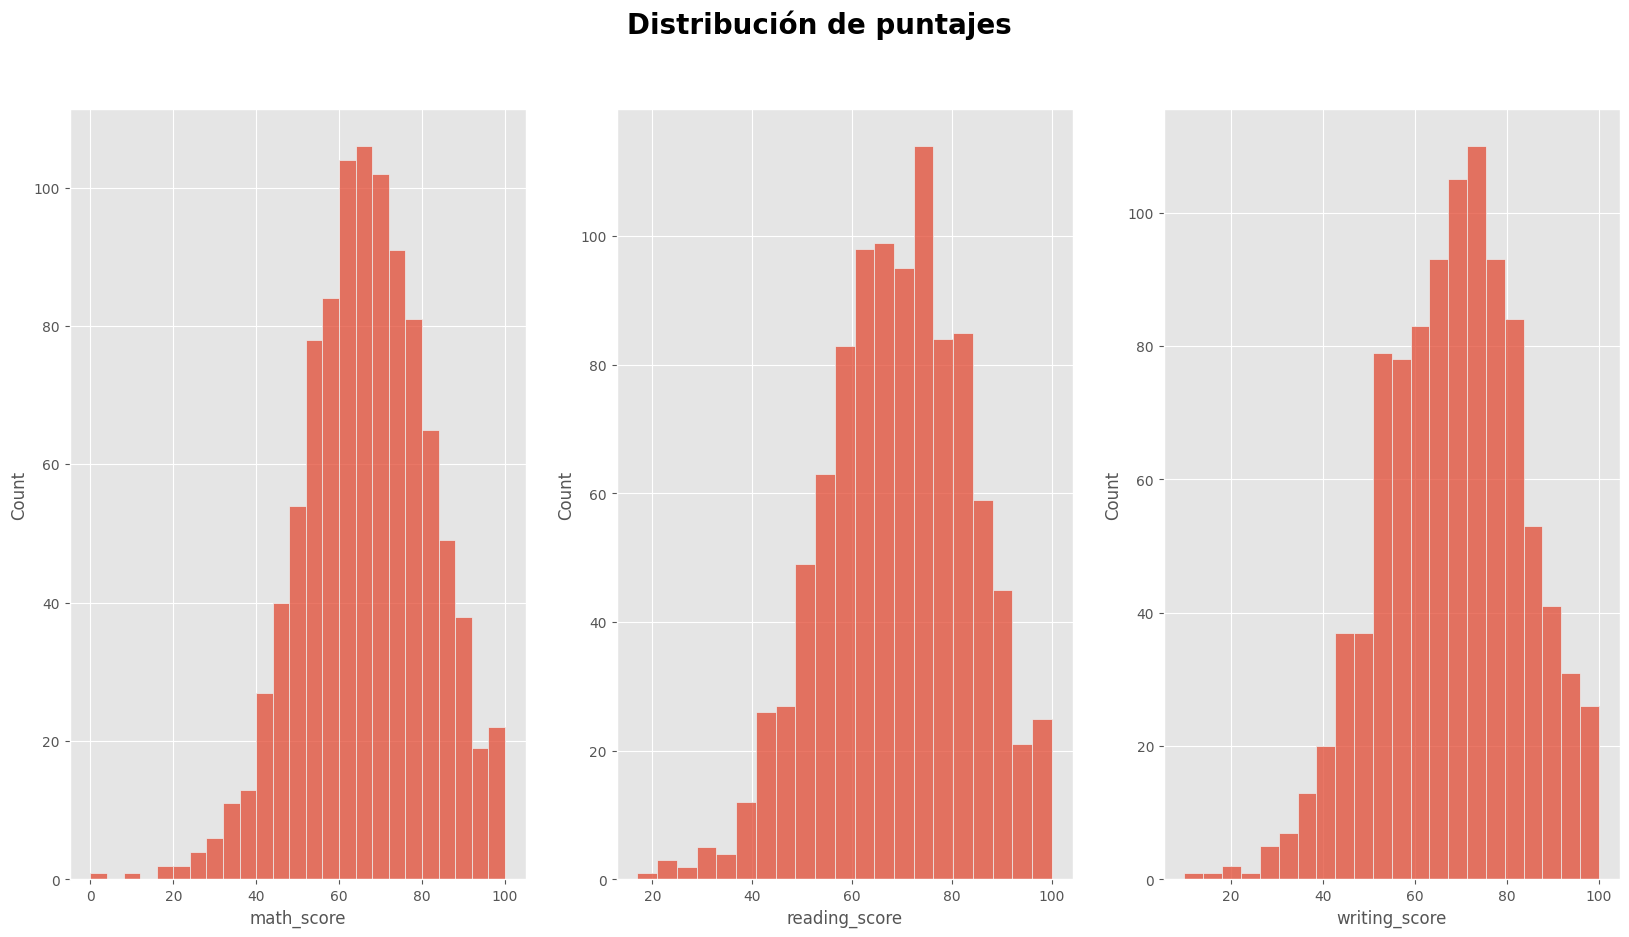

In [14]:
fig, ax = plt.subplots(1,3)
plt.suptitle("Distribución de puntajes", fontsize=20, horizontalalignment="center", fontweight="bold")
i = 0
for column in ['math_score', 'reading_score', 'writing_score']:
  sb.histplot(data_frame[column], ax = ax[i], kde=False)
  i+=1
plt.show()

## Aplicación del algoritmo

***Objetivo***

Establecer grupos de estudiantes con el fin de poder buscar similitud en sus resultados de forma de poder abordar sus debilidades en cada área

In [67]:
# Selección de variables numéricas y categóricas
features_num = ["math_score", "reading_score", "writing_score"]
features_cat = ["parental_level_of_education"]

preproceso_numericas = Pipeline([
    ("winsorizer", Winsorizer()),
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preproceso_categoricas = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop=None, handle_unknown='ignore', sparse_output=False))
])

# Preprocesamiento: escala lo numérico y codifica lo categórico
preprocessor_for_k = ColumnTransformer([
    ("num", preproceso_numericas, features_num),
    ("cat", preproceso_categoricas, features_cat)
])

In [68]:
features = features_num + features_cat
features

['math_score', 'reading_score', 'writing_score', 'parental_level_of_education']

In [69]:
X_transformed = preprocessor_for_k.fit_transform(data_frame[features])

In [71]:
# Experimentar con valor de k
inertias, silhouettes = [], []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=29)
    km.fit(X_transformed)
    # Almacena inercias y el valor de una métrica
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_transformed, km.labels_))

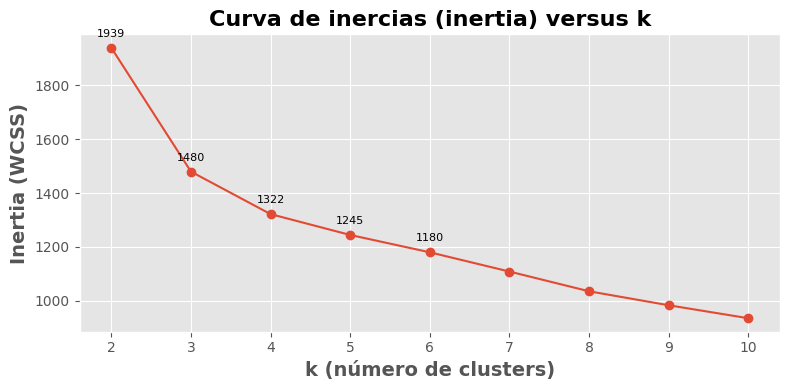

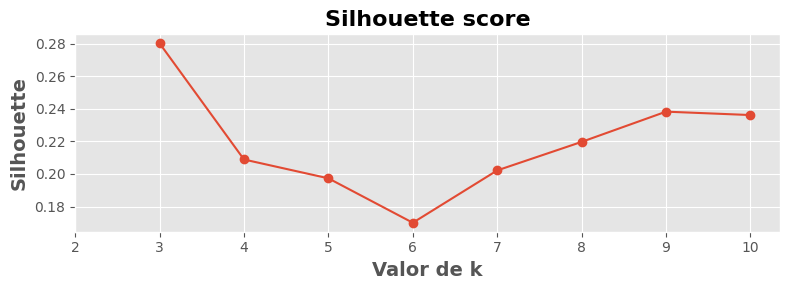

In [72]:
# Graficar inertias (Elbow plot)
range_k = range(2, 11)
plt.figure(figsize=(8,4))
plt.plot(list(range_k), inertias, marker='o')
plt.title("Curva de inercias (inertia) versus k", fontsize=16, fontweight="bold")
plt.xlabel("k (número de clusters)", fontsize=14, fontweight="bold")
plt.ylabel("Inertia (WCSS)", fontsize=14, fontweight="bold")
plt.xticks(list(range_k))

for k_val, val in zip(list(range_k), inertias):
    if k_val <= 6:
        plt.annotate(f"{val:.0f}", (k_val, val), textcoords="offset points", xytext=(0,8), ha='center', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

# Grafica el índice de silhoutte
plt.figure(figsize=(8,3))
plt.plot(list(range_k)[1:], silhouettes[1:], marker='o')
plt.title("Silhouette score", fontsize=16, fontweight="bold")
plt.xlabel("Valor de k", fontsize=14, fontweight="bold")
plt.ylabel("Silhouette", fontsize=14, fontweight="bold")
plt.xticks(list(range_k))
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
# Obtiene el mejor valor de k
kl = KneeLocator(range_k, inertias, curve="convex", direction="decreasing")
print(f"El codo está en k = {kl.elbow}")
print(f"Valor de la inercia = {kl.all_elbows_y[0]: .2f}")

El codo está en k = 4
Valor de la inercia =  1322.00


## Ejecución del algoritmo

Se ejecuta el algoritmo para la cantidad de clusters indicada por `KneeLocator` y se obtienen las etiquetas y los centroides.

In [83]:
# Ahora si el preprocessor definitivo
preproceso_numericas = Pipeline([
    ("winsorizer", Winsorizer()),
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preproceso_categoricas = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop=None, handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", preproceso_numericas, features_num),
    ("cat", preproceso_categoricas, features_cat)
])

pipeline_final = Pipeline([
    ("preprocessor", preprocessor),
    ("kmeans", KMeans(n_clusters=kl.elbow, random_state=29))
])

In [84]:
pipeline_final.fit(data_frame[features])

clusters = pipeline_final.predict(data_frame[features])
data_frame["cluster"] = clusters

In [77]:
data_frame.head()

,user,gender,race/ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,cluster
0,1,female,group B,bachelor's degree,standard,none,72,72,74,0
1,2,female,group C,some college,standard,completed,69,90,88,2
2,3,female,group B,master's degree,standard,none,90,95,93,2
3,4,male,group A,associate's degree,free/reduced,none,47,57,44,1
4,5,male,group C,some college,standard,none,76,78,75,0


In [85]:
# Obtener el modelo entrenado
kmeans = pipeline_final.named_steps["kmeans"]

# Obtener los centroides en el espacio transformado
centroides_transformados = kmeans.cluster_centers_

print(centroides_transformados)

[[ 0.34928657  0.46088095  0.45470912  0.24752475  0.11881188  0.18151815
   0.05610561  0.22772277  0.16831683]
 [-1.28683714 -1.3771769  -1.3952648   0.21428571  0.07142857  0.3
   0.03333333  0.16190476  0.21904762]
 [ 1.29073581  1.3144589   1.29608235  0.25980392  0.17156863  0.08823529
   0.10294118  0.23039216  0.14705882]
 [-0.34949871 -0.4190438  -0.38576697  0.17314488  0.1130742   0.21201413
   0.04946996  0.26855124  0.18374558]]


In [91]:
def obtener_centroides_originales(pipeline: Pipeline, features_num: np.array, features_cat: np.array) -> pd.DataFrame:
  """
  Obtiene los centroides originales en escala original.

  Parámetros:
    pipeline: pipeline final (preprocesamiento + KMeans)
    features_num: nombres de las columnas numéricas
    features_cat: nombres de las columnas categóricas

  Retorna: DataFrame
  """

  # Extraer componentes
  preprocessor = pipeline.named_steps["preprocessor"]
  kmeans = pipeline.named_steps["kmeans"]

  centroides = kmeans.cluster_centers_

  num_pipe = preprocessor.named_transformers_["num"]
  cat_pipe = preprocessor.named_transformers_["cat"]

  scaler = num_pipe.named_steps["scaler"]
  ohe = cat_pipe.named_steps["encoder"]

  n_num = len(features_num)

  resultados = []

  for centroide in centroides:
    # Numéricas
    centroide_num = centroide[:n_num]
    centroide_num_orig = scaler.inverse_transform(
    centroide_num.reshape(1, -1))[0]

    # Categóricas
    centroide_cat = centroide[n_num:]

    categorias = []
    start = 0

    for cats in ohe.categories_:
      size = len(cats)
      bloque = centroide_cat[start:start + size]
      categorias.append(cats[np.argmax(bloque)])
      start += size

    # Agrega los centroides originales y cetegóricas
    resultados.append(list(centroide_num_orig) + categorias)
  columnas = features_num + features_cat
  return pd.DataFrame(resultados, columns=columnas)


In [92]:
# Obtiene los centroides originales
df_centroides = obtener_centroides_originales(
    pipeline_final,
    features_num,
    features_cat
)

df_centroides

,math_score,reading_score,writing_score,parental_level_of_education
0,71.046370,75.445545,74.544554,associate's degree
1,48.607381,50.828571,48.807143,high school
2,83.958088,86.877451,86.250000,associate's degree
3,61.462721,63.660777,62.851590,some college


In [57]:
def graficar_clusters_3d(df : pd.DataFrame, df_centroides: pd.DataFrame,
                         x: str, y = str, z = str,
                         cluster_col="cluster",
                         ) -> None:
    """
    Grafica los datos y centroides en 3D.

    Parámetros:
        df              -> DataFrame original con columna "cluster"
        df_centroides   -> centroides recuperados en escala original
        cluster_col     -> nombre de la columna con el cluster asignado
        x, y, z         -> nombres de las columnas numéricas a graficar
    """

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Graficar puntos del dataset
    scatter = ax.scatter(
        df[x],
        df[y],
        df[z],
        c=df[cluster_col],
        cmap='tab10',
        s=30,
        alpha=0.6
    )

    # Graficar centroides
    ax.scatter(
        df_centroides[x],
        df_centroides[y],
        df_centroides[z],
        s=300,
        c="black",
        marker="X",
        edgecolor="white",
        linewidth=1.5,
        label="Centroides"
    )

    ax.set_xlabel(x, fontsize=16, fontweight="bold")
    ax.set_ylabel(y, fontsize=16, fontweight="bold")
    ax.set_zlabel(z, fontsize=16, fontweight="bold")

    ax.set_title("Clusters en 3D con centroides originales", fontsize=16, fontweight="bold")
    ax.legend()

    plt.show()


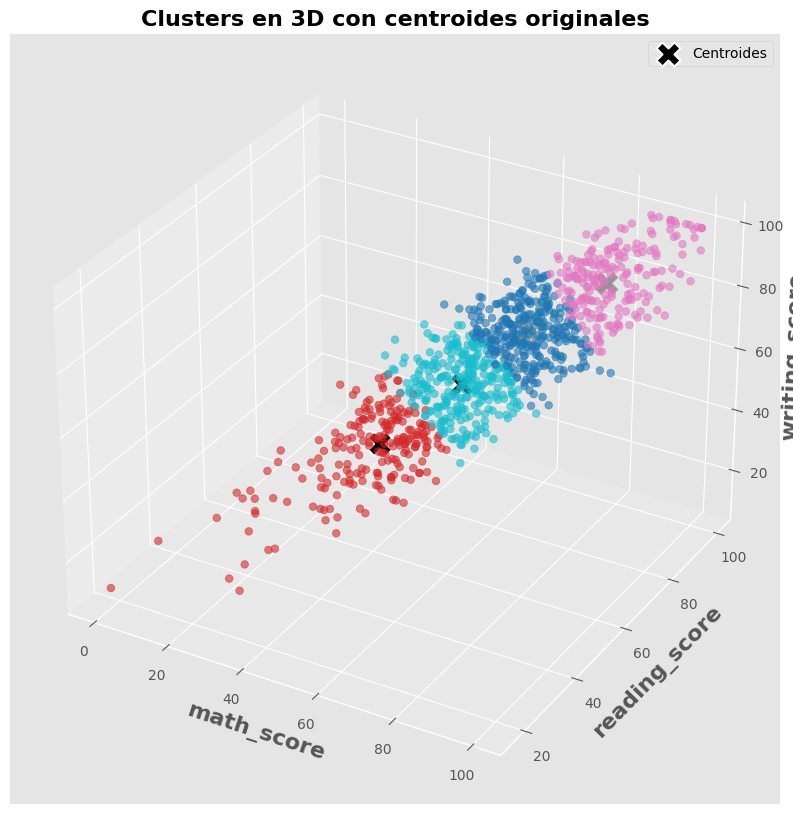

In [58]:
graficar_clusters_3d(
    data_frame,
    df_centroides,
    cluster_col="cluster",
    x="math_score",
    y="reading_score",
    z="writing_score"
)


## Clasificación de nuevas muestras

In [59]:
def predecir_cluster(nuevos_valores: np.array, pipeline_entrenado):
    """
    nuevos_valores: dict o DataFrame con las columnas originales
    pipeline_entrenado: pipeline final (preprocesamiento + KMeans)

    Retorna: cluster asignado por KMeans
    """
    df_nuevo = pd.DataFrame([nuevos_valores])
    cluster = pipeline_entrenado.predict(df_nuevo)
    return cluster[0]


In [60]:
features

['math_score', 'reading_score', 'writing_score', 'parental_level_of_education']

## Caso 1

In [61]:
nuevo_registro = {
    "math_score": 35,
    "reading_score": 42,
    "writing_score": 50,
    "parental_level_of_education": "high school"
}

cluster_predicho = predecir_cluster(nuevo_registro, pipeline_final)
print(f"El nuevo registro pertenece al cluster: {cluster_predicho}")

El nuevo registro pertenece al cluster: 1


In [62]:
# Revisa características de cluster al que pertenece la nueva observación
data_frame.query(f"cluster == {cluster_predicho}")[features_num].describe().T

,count,mean,std,min,25%,50%,75%,max
math_score,210.0,46.628571,10.151727,0.0,41.00,48.0,53.0,64.0
reading_score,210.0,49.219048,8.447962,17.0,44.25,51.0,55.0,64.0
writing_score,210.0,46.966667,8.506897,10.0,43.00,48.5,53.0,61.0


## Caso 2

In [63]:
nuevo_registro = {
    "math_score": 95,
    "reading_score": 92,
    "writing_score": 90,
    "parental_level_of_education": "high school"
}

cluster_predicho = predecir_cluster(nuevo_registro, pipeline_final)
print("El nuevo registro pertenece al cluster:", cluster_predicho)

# Revisa características de cluster al que pertenece la nueva observación
data_frame.query(f"cluster == {cluster_predicho}")[features_num].describe().T

El nuevo registro pertenece al cluster: 2


,count,mean,std,min,25%,50%,75%,max
math_score,204.0,85.161765,7.231452,69.0,79.0,85.0,90.0,100.0
reading_score,204.0,88.024510,6.271712,73.0,84.0,87.0,92.0,100.0
writing_score,204.0,87.338235,6.860920,73.0,82.0,87.0,92.0,100.0


# Evaluación del modelo

| Métrica           | Interpretación              | Mejor valor | Útil para                          |
| ----------------- | --------------------------- | ----------- | ---------------------------------- |
| Inertia (SSE)     | Compacidad                  | Bajo        | Elbow method                       |
| Silhouette        | Separación/compactación     | Alto        | Mejor métrica global               |
| Calinski-Harabasz | Dispersión entre vs. dentro | Alto        | Clusters muy distintos             |
| Davies-Bouldin    | Similitud entre clusters    | Bajo        | Identificar clusters muy parecidos |


## Silhouette

La métrica más usada para evaluar la calidad global del clustering.

Rango: −1 a 1

1 -> Clusters muy bien separados

0 -> Puntos entre clusters

Puede darse el caso de que sea negativo -> Errores (puntos mal asignados)

## Calinski-Harabasz

Evalúa relación entre dispersión interna de los clusters y separación entre clusters.

`Mientras más alto el valor, mejor.`

## Davies-Bouldin

Mide la similitud media entre cada cluster y su más cercano.

`Mientras más bajo el valor, mejor. Valor 0 es perfeccción`.

In [64]:
labels = pipeline_final.named_steps["kmeans"].labels_
X_transformed = pipeline_final.named_steps["preprocessor"].transform(data_frame[features])

# Obtiene las métricas
silhouette = silhouette_score(X_transformed, labels)
ch = calinski_harabasz_score(X_transformed, labels)
db = davies_bouldin_score(X_transformed, labels)

print(f"{'Silhouette Score':<25} : {silhouette: .4f}")
print(f"{'Calinski-Harabasz':<25} : {ch: .4f}")
print(f"{'Davies-Bouldin':<25} : {db: .4f}")

Silhouette Score          :  0.2089
Calinski-Harabasz         :  625.2875
Davies-Bouldin            :  1.5248


## Conclusiones

El algoritmo de K-means ayudará a crear clusters cuando se tienen grandes grupos de datos sin etiquetar, cuando se quiera intentar descubrir nuevas relaciones entre features o para probar o declinar hipótesis que se tienen del negocio.

Puede haber casos en los que no existan grupos naturales, o clusters que contengan una verdadera razón de ser. Si bien K-means siempre brindará `k clusters`, quedará a criterio reconocer la utilidad de los mismos o bien revisar las features y descartar las que no sirven o conseguir nuevas.

Se debe tener en cuenta que en este ejemplo se utilizó como medida de similitud entre features la distancia Euclidiana. Sin embargo, se puede utilizar otras funciones que podrían arrojar mejores resultados (como Manhattan, Lavenshtein, Mahalanobis, entre otros).

# Desafíos

+ Segmentar usando sólo las variables de los resultados de las prueba de matemáticas, lectura y escritura
+ Segmentar considerando la participación del curso de preparación, ¿tiene sentido?
+ El mismo desafio anterior considerando el género
